# Primero cargar datos de precios

Los datos de electricidad se obtuvieron de la OFGEM https://www.ofgem.gov.uk/data-portal/all-charts/policy-area/electricity-wholesale-markets 

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import os

sns.set_style('dark')
sns.color_palette("cubehelix", 8)

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


Información de la base de datos:
--------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103 entries, 2010-06-01 to 2018-12-01
Data columns (total 1 columns):
Price    103 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB
None
            Price
count  103.000000
mean    46.693398
std      7.368920
min     33.850000
25%     41.880000
50%     46.400000
75%     50.775000
max     67.690000


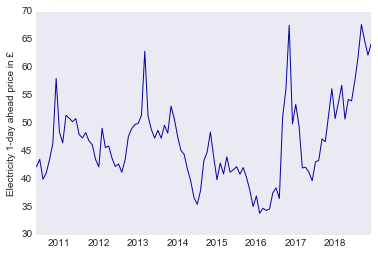

In [72]:
df = pd.read_csv('electricity_prices.csv')
df['Date'] = pd.to_datetime(df['Date'], format= "%d/%m/%Y")
df = df.set_index('Date')
df.plot(color = sns.xkcd_rgb["royal blue"], legend = False)
plt.ylabel('Electricity 1-day ahead price in £')
plt.xlabel('')

print("Información de la base de datos:")
print("--------------------------------")
print(df.info())
print(df.describe())
#print(df.plot(color = sns.xkcd_rgb["blue green"]))



# Monte Carlo

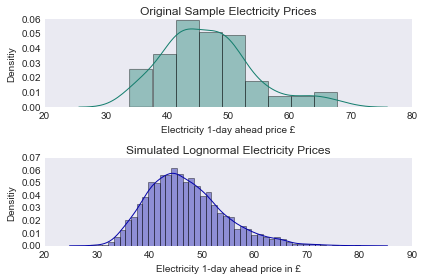

In [100]:
# Find distribution
from scipy import stats

# Fit lognormal and normal to find parameters
log_shape, log_loc, log_scale = stats.lognorm.fit(df["Price"])
random_log = stats.lognorm.rvs(s = log_shape, loc = log_loc, scale = log_scale, size = 5000, random_state = 1234)


plt.subplot(211)
sns.distplot(df['Price'], color = sns.xkcd_rgb["blue green"])
plt.xlabel('Electricity 1-day ahead price £')
plt.ylabel('Densitiy')
plt.title('Original Sample Electricity Prices')



plt.subplot(212)
sns.distplot(random_log, color = sns.xkcd_rgb["royal blue"])
plt.xlabel('Electricity 1-day ahead price in £')
plt.ylabel('Densitiy')
plt.title('Simulated Lognormal Electricity Prices')
             


plt.tight_layout()

## Estimar mejor distribución de los datos

## Modelo a estimar

## Simulaciones y resultados de interés

In [101]:
def profits(price, quantity, variablecost, fixedcost):
    revenues = price*quantity
    total_costs = (variablecost*quantity)+fixedcost
    profit = revenues - total_costs
    return profit

q = 500
mc = 40
fixed = 1000
price = 45

#Run simulation

NPV = []

for i in random_log:
    npv = profits(i,q,mc,fixed)
    NPV.append(npv)

mean_NPV = np.mean(NPV)
sd_NPV = np.std(NPV)
max_npv = np.max(NPV)
min_NPV = np.min(NPV)
    


# Resultados del Monte carlo    
    
print('Average NPV:'+ str(mean_NPV))
print('Stanard Deviation of NPV:' + str(sd_NPV))
print('Maximum NPV:' + str(max_npv))
print('Minimium NPV:' + str(min_NPV))

# Calculate probability of loss
NPV = np.array(NPV)
negnpv = NPV[(NPV < 0)]
lossprob = np.round(len(negnpv) / len(NPV), 4) * 100
print('Probability of negative NPV:' + str(lossprob) + '%')



#Calculate confidence intervals
z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value at 5%*
margin_of_error = 1.96 * math.sqrt(sd_NPV**2/len(NPV))
confidence_interval = (mean_NPV - margin_of_error, mean_NPV + margin_of_error) 
print("95% Confidence Interval:")
print(str(confidence_interval[0]) + " a " + str(confidence_interval[1]))      

Average NPV:2426.36372958
Stanard Deviation of NPV:3650.92935015
Maximum NPV:19638.5774912
Minimium NPV:-6614.70779891
Probability of negative NPV:27.16%
95% Confidence Interval:
2325.16513106 a 2527.56232811


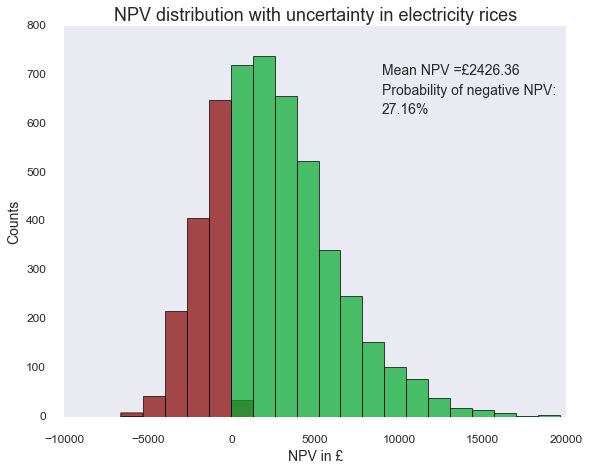

In [116]:
# Try histogram with two colors
# make equal binning through the range, you can adapt the bin size here
NPV = np.array(NPV)
counts, bins = np.histogram(NPV, bins=20)

# here we do the filtering and split the observations based on color code
x1 = NPV[(NPV < 0)]
x2 = NPV[(NPV >= 0)]

# finally, do the plot
f, ax = plt.subplots(figsize = (9,7))
ax.hist(x1, bins=bins, color = sns.xkcd_rgb["dark red"], alpha = 0.7)
ax.hist(x2, bins=bins, color = sns.xkcd_rgb["kelly green"], alpha = 0.7)
plt.xlabel('NPV in £', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('NPV distribution with uncertainty in electricity rices', fontsize = 18)
plt.tick_params(labelsize=12, pad=6)
ax.text(9000, 700, 'Mean NPV =' + '£' + str(np.round(mean_NPV,2)), fontsize=14)
ax.text(9000, 660, 'Probability of negative NPV:', fontsize=14)
ax.text(9000, 620, str(np.round(lossprob,2)) + '%', fontsize=14)
sns.despine()

# Monte Carlo with two uncertain variables

In [117]:
# Draw random sample from Uniform Distribution
# Assume costs can be random from 35 pouns to 50
random_uniform = np.random.uniform(35,50,5000)
random_uniform

q = 500
fixed = 1000

#Run simulation
# Función para calcular profits a partir el data frame
def profits(df):
    revenues = df['sim_prices']*q
    total_costs = (df['sim_costs']*q)+fixed
    profit = revenues - total_costs
    return profit

# Data frame for both random draws

MC_df = pd.DataFrame({'sim_prices': random_log,
                      'sim_costs': random_uniform})

MC_df['NPV'] = MC_df.apply(profits, axis=1)
MC_df.describe()


,sim_costs,sim_prices,NPV
count,5000.000000,5000.000000,5000.000000
mean,42.522639,46.852727,1165.044279
std,4.356136,7.302589,4239.982252
min,35.002727,28.770584,-9902.629949
25%,38.663521,41.601161,-1896.633013
50%,42.556686,45.942682,826.236217
75%,46.366633,51.077017,3879.282396
max,49.996359,81.277155,18911.860406


In [119]:
mean_NPV = MC_df['NPV'].mean()
sd_NPV = MC_df['NPV'].std()
max_npv = MC_df['NPV'].max()
min_NPV = MC_df['NPV'].min()
    
# Resultados del Monte carlo    
    
print('Average NPV:'+ str(mean_NPV))
print('Stanard Deviation of NPV:' + str(sd_NPV))
print('Maximum NPV:' + str(max_npv))
print('Minimium NPV:' + str(min_NPV))

# Calculate probability of loss
NPV = np.array(MC_df['NPV'])
negnpv = NPV[(NPV < 0)]
lossprob = np.round(len(negnpv) / len(NPV), 4) * 100
print('Probability of negative NPV:' + str(lossprob) + '%')

#Calculate confidence intervals
z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value at 5%*
margin_of_error = 1.96 * math.sqrt(sd_NPV**2/len(NPV))
confidence_interval = (mean_NPV - margin_of_error, mean_NPV + margin_of_error) 
print("95% Confidence Interval:")
print(str(confidence_interval[0]) + " a " + str(confidence_interval[1]))    

Average NPV:1165.04427878
Stanard Deviation of NPV:4239.98225186
Maximum NPV:18911.860406
Minimium NPV:-9902.62994886
Probability of negative NPV:42.48%
95% Confidence Interval:
1047.51796684 a 1282.57059071


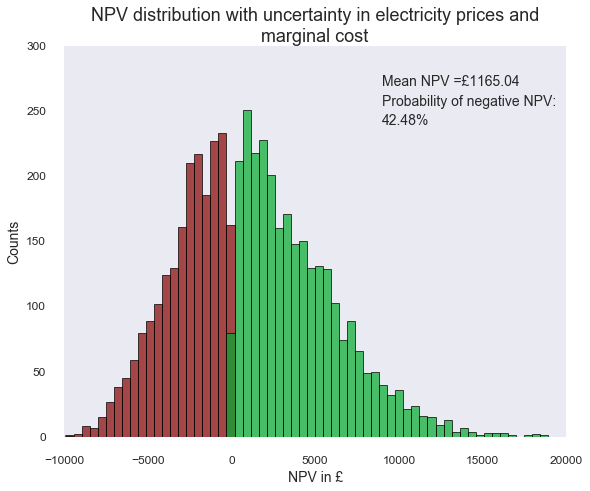

In [134]:
# Try histogram with two colors
# make equal binning through the range, you can adapt the bin size here
NPV = np.array(NPV)
counts, bins = np.histogram(NPV, bins=60)

# here we do the filtering and split the observations based on your color code
x1 = NPV[(NPV < 0)]
x2 = NPV[(NPV >= 0)]

# finally, do the plot
f, ax = plt.subplots(figsize = (9,7))
ax.hist(x1, bins=bins, color = sns.xkcd_rgb["dark red"], alpha = 0.7)
ax.hist(x2, bins=bins, color = sns.xkcd_rgb["kelly green"], alpha = 0.7)
plt.xlabel('NPV in £', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
ax.set_title("\n".join(wrap('NPV distribution with uncertainty in electricity prices and marginal cost', 60)),
            fontsize =  18)
plt.tick_params(labelsize=12, pad=6)
ax.text(9000, 270, 'Mean NPV =' + '£' + str(np.round(mean_NPV,2)), fontsize=14)
ax.text(9000, 255, 'Probability of negative NPV:', fontsize=14)
ax.text(9000, 240, str(np.round(lossprob,2)) + '%', fontsize=14)
sns.despine()